In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tkinter as tk
from PIL import Image, ImageDraw
from tqdm import tqdm

graphics_path = r'C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\acc_graphics'


# Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\datasets\train.csv")


data = np.array(df)

np.random.seed(0)

muestras, columnas = data.shape
print(muestras, columnas)

np.random.shuffle(data) # mezclo para evitar overffitting



data_test = data[40000:, :].T # hago que cada uestra sea una columna y no una fila como antes
Y_test = data_test [0]
X_test = data_test [1:]
X_test = X_test / 255.

data_train = data[:40000].T # hago que cada muestra sea una columna y no una fila como antes
Y_train = data_train[0] # la col 0 es el label
X_train = data_train[1:]
X_train = X_train / 255.

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)


42000 785
(784, 2000)
(2000,)
(784, 40000)
(40000,)


  0%|          | 10/20000 [00:00<03:24, 97.90it/s]C:\Users\Martin\AppData\Local\Temp\ipykernel_1244\276074171.py:32: RuntimeWarning: invalid value encountered in divide
  return exp_Z / exp_Z.sum(axis=0)
 17%|█▋        | 3473/20000 [00:24<05:25, 50.75it/s] C:\Users\Martin\AppData\Local\Temp\ipykernel_1244\276074171.py:31: RuntimeWarning: invalid value encountered in subtract
  exp_Z = np.exp(Z - np.max(Z))
C:\Users\Martin\AppData\Local\Temp\ipykernel_1244\276074171.py:37: RuntimeWarning: overflow encountered in matmul
  Z2 = self.w_output @ A1 + self.b_output
100%|██████████| 20000/20000 [01:54<00:00, 173.97it/s]


test: 0.126  train : 0.096


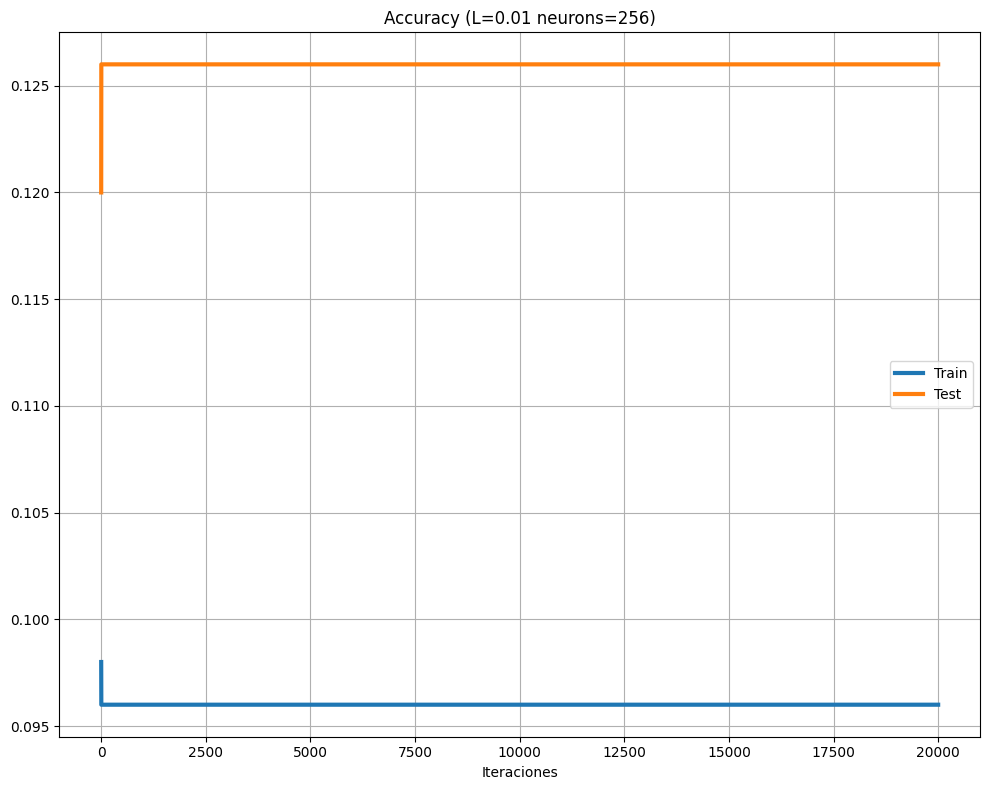

In [27]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, neurons, learning_rate, iterations):
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.iterations = iterations
        
        # Inicializar pesos y sesgos
        self.w_hidden = np.random.rand(self.neurons, 784) - 0.5
        self.w_output = np.random.rand(10, self.neurons) - 0.5
        self.b_hidden = np.random.rand(self.neurons, 1) - 0.5
        self.b_output = np.random.rand(10, 1) - 0.5

        self.accuracy_train_l = []
        self.accuracy_test_l = []
        
        subset_size = 500
        
        self.X_train_subset = X_train[:, 0:subset_size]
        self.Y_train_subset = Y_train[0:subset_size]
        self.X_test_subset = X_test[:, 0:subset_size]
        self.Y_test_subset = Y_test[0:subset_size]

    # Funciones de activación
    def relu(self, x):
        return np.maximum(x, 0)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z))
        return exp_Z / exp_Z.sum(axis=0)

    def forward_prop(self, X):
        Z1 = self.w_hidden @ X + self.b_hidden
        A1 = self.relu(Z1)
        Z2 = self.w_output @ A1 + self.b_output
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def one_hot_encode(self, Y):
        one_hot_Y = np.zeros((10, Y.shape[0]))
        one_hot_Y[Y] = 1
        return one_hot_Y

    def d_relu(self, x):
        return x > 0

    def backward_prop(self, Z1, A1, Z2, A2, X, Y):
        one_hot_Y = self.one_hot_encode(Y)
        
        dL_dA2 = 2 * (A2 - one_hot_Y)  # Gradiente de la pérdida respecto a la salida
        
        dL_dZ2 = np.zeros_like(A2)  # Inicializar el gradiente para Z2

        for j in range(A2.shape[0]):  # Para cada clase
            if j == Y:
                dL_dZ2[j] = dL_dA2[j] @ (A2[j] * (1 - A2[j]))
            else:
                dL_dZ2[j] = dL_dA2[j] @ (-A2[j] * A2[j])
                    
                    
        dZ2 = dL_dZ2
        dC_dW2 = dZ2.dot(A1.T)
        dC_dB2 = np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = self.w_output.T.dot(dZ2) * self.d_relu(Z1)
        dC_dW1 = dZ1.dot(X.T)
        dC_dB1 = np.sum(dZ1, axis=1, keepdims=True)
        return dC_dW1, dC_dB1, dC_dW2, dC_dB2

    def train(self, X_train, Y_train, X_test, Y_test):
        for i in tqdm(range(self.iterations)):
            # seleccionar aleatoriamente uno de los datos de entrenamiento
            idx = np.random.choice(X_train.shape[1], 1, replace=False)
            X_sample = X_train[:, idx]
            Y_sample = Y_train[idx]

            # pasar datos seleccionados aleatoriamente a través de la red neuronal
            Z1, A1, Z2, A2 = self.forward_prop(X_sample)

            # distribuir error a través de la retropropagación
            dW1, dB1, dW2, dB2 = self.backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

            # actualizar pesos y sesgos
            self.w_hidden -= self.learning_rate * dW1
            self.b_hidden -= self.learning_rate * dB1
            self.w_output -= self.learning_rate * dW2
            self.b_output -= self.learning_rate * dB2
            

            # Calcular precisión del conjunto de prueba
            test_predictions = self.forward_prop(self.X_test_subset)[3]
            test_comparisons = np.argmax(test_predictions, axis=0) == self.Y_test_subset
            accuracy_test = np.mean(test_comparisons)
            self.accuracy_test_l.append(accuracy_test)
                
            # Calcular precisión del conjunto de entrenamiento
            train_predictions = self.forward_prop(self.X_train_subset)[3]
            train_comparisons = np.argmax(train_predictions, axis=0) == self.Y_train_subset
            accuracy_train = np.mean(train_comparisons)
            self.accuracy_train_l.append(accuracy_train)

                # Imprimir la pérdida y la precisión
            loss = np.mean((A2 - self.one_hot_encode(Y_sample)) ** 2)  # Pérdida cuadrática media
                
        print(F"test: {accuracy_test}  train : {accuracy_train}")
        self.accuracy_graphic(self.learning_rate, self.accuracy_train_l, self.accuracy_test_l, self.neurons)

    def accuracy_graphic(self, L, train_l, test_l, neurons):
        iters = self.iterations
        fmt_train = {
            'color': 'tab:blue',
            'ls': 'solid',
            'lw': 3,
        }
        fmt_test = {
            'color': 'tab:orange',
            'ls': 'solid',
            'lw': 3,
        }

        fig, (ax) = plt.subplots(1, 1, figsize=(10, 8))
        ax.plot(train_l, label='Train', **fmt_train)
        ax.plot(test_l, label='Test', **fmt_test)

        ax.grid(which='both')
        ax.legend()
        ax.set_title(f'Accuracy ({L=} {neurons=})')
        ax.set_xlabel('Iteraciones')

        fig.tight_layout()
        plt.savefig( os.path.join(graphics_path, f"accuracy_{L=}_{iters=}_{neurons=}.png"))
        plt.show()


# Ejemplo de uso
iters = 20_000
L = 0.01
neurons = 256

nn = NeuralNetwork(neurons, L, iters)
nn.train(X_train, Y_train, X_test, Y_test)

In [2]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=42)

# Crear y entrenar la red neuronal
nn = MLPClassifier(solver='sgd',
                   hidden_layer_sizes=(64, ),  # Capas más grandes dado el tamaño del problema
                   activation='relu',
                   max_iter=10_000,
                   learning_rate_init=.01)

nn.fit(X_train, Y_train)

# Imprimir los pesos y sesgos
# print(nn.coefs_)
# print(nn.intercepts_)

# Evaluación del modelo
print("Puntaje del conjunto de entrenamiento: %f" % nn.score(X_train, Y_train))
print("Puntaje del conjunto de prueba: %f" % nn.score(X_test, Y_test))



Puntaje del conjunto de entrenamiento: 0.999850
Puntaje del conjunto de prueba: 0.970344


In [9]:
import tkinter as tk
from PIL import Image, ImageDraw
import numpy as np
import os

# Configuración global
carpeta_guardado = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist' # Cambia esta ruta a tu carpeta donde quieres guardar las imágenes
imagen_contador = 0  # Para dar nombres únicos a las imágenes guardadas

# Crear la ventana de tkinter
class DibujarNumero:
    def __init__(self, root):
        self.root = root
        self.root.title("Dibuja un número")
        
        # Crear un lienzo de 20x20 para dibujar
        self.canvas = tk.Canvas(self.root, width=200, height=200, bg='black')
        self.canvas.grid(row=0, column=0, pady=2, sticky=tk.W, columnspan=2)
        
        # Configurar eventos para el dibujo
        self.canvas.bind("<B1-Motion>", self.dibujar)
        
        # Botón para guardar el dibujo
        self.guardar_btn = tk.Button(self.root, text="Guardar Dibujo", command=self.guardar_dibujo)
        self.guardar_btn.grid(row=1, column=0, pady=2)
        
        # Botón para limpiar el lienzo
        self.limpiar_btn = tk.Button(self.root, text="Limpiar", command=self.limpiar_lienzo)
        self.limpiar_btn.grid(row=1, column=1, pady=2)
        
        # Crear una imagen para dibujar en ella (PIL)
        self.imagen_pil = Image.new("L", (20, 20), 0)  # Fondo blanco
        self.draw = ImageDraw.Draw(self.imagen_pil)
        self.root.protocol("WM_DELETE_WINDOW", self.cerrar_aplicacion)

    def dibujar(self, event):
        # Dibujar un pequeño círculo donde se haga clic
        x, y = event.x, event.y
        r = 4  # Radio del "pincel"
        
        # Dibujar en el canvas de tkinter
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill='white', outline='white')
        
        # Dibujar en la imagen PIL (convertimos coordenadas 200x200 a 20x20)
        self.draw.ellipse((x / 10 - r / 10, y / 10 - r / 10, x / 10 + r / 10, y / 10 + r / 10), fill='white')
    
    def limpiar_lienzo(self):
        # Limpiar el canvas de tkinter
        self.canvas.delete("all")
        
        # Limpiar la imagen PIL
        self.imagen_pil = Image.new("L", (20, 20), 0)  # Fondo blanco
        self.draw = ImageDraw.Draw(self.imagen_pil)
    
    def guardar_dibujo(self):
        global imagen_contador
        
        # Añadir 4 píxeles de margen en cada dirección (crear una imagen de 28x28)
        imagen_28x28 = Image.new("L", (28, 28), 0)  # Crear una nueva imagen 28x28 con fondo blanco
        imagen_28x28.paste(self.imagen_pil, (4, 4))  # Pegar la imagen 20x20 en el centro con 4 píxeles de margen
        
        # Guardar la imagen
        ruta_imagen = os.path.join(carpeta_guardado, f"numero_{imagen_contador}.png")
        imagen_28x28.save(ruta_imagen)
        print(f"Imagen guardada en: {ruta_imagen}")
        
        # Incrementar el contador para la próxima imagen
        imagen_contador += 1
        
        # Limpiar el lienzo después de guardar
        self.limpiar_lienzo()
    def cerrar_aplicacion(self):
        print("Cerrando la aplicación...")
        self.root.destroy()  # Detener el mainloop y cerrar la ventana

# Crear la ventana de tkinter
root = tk.Tk()

# Iniciar la aplicación de dibujo
app = DibujarNumero(root)

# Ejecutar el mainloop de tkinter
root.mainloop()

Imagen guardada en: \Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist\numero_0.png
Cerrando la aplicación...


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


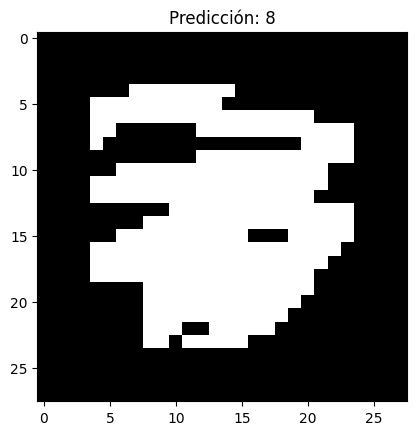

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


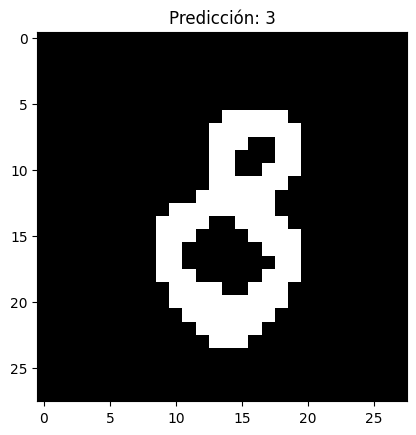

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


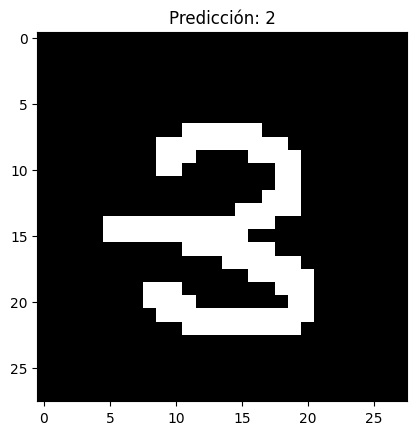

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


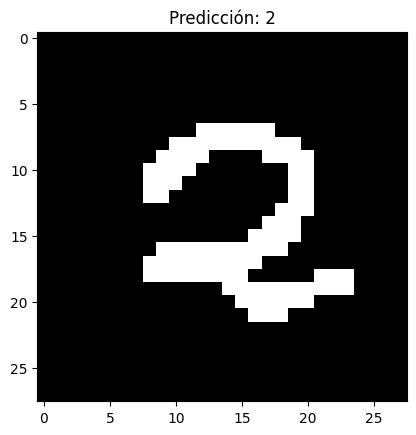

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


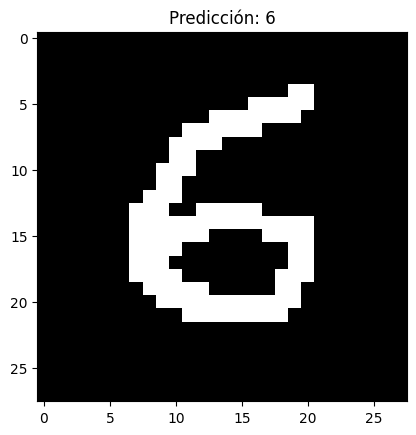

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


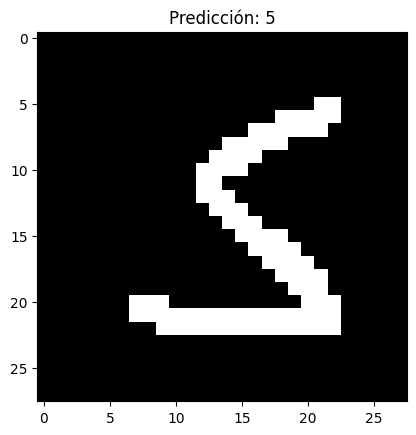

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


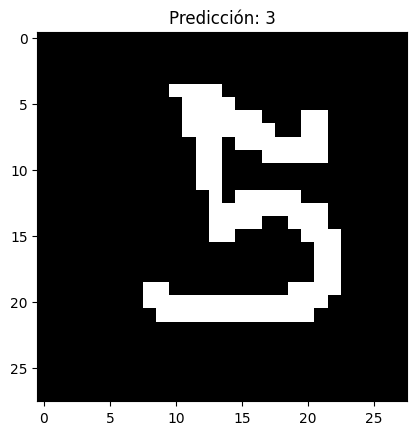

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


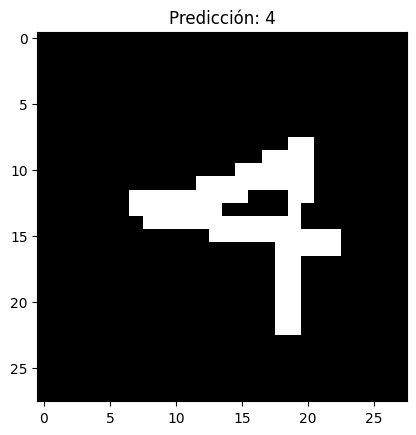

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


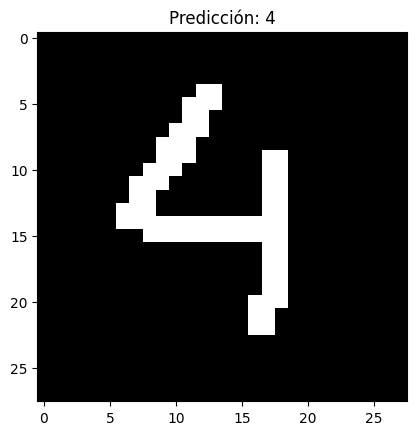

c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


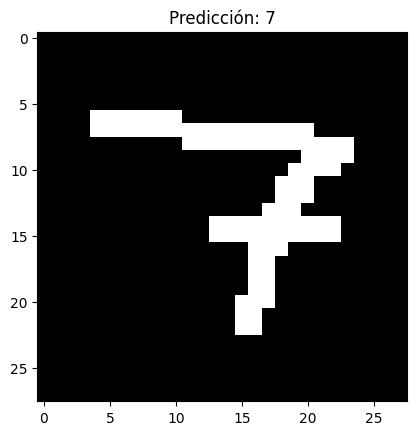

In [10]:
# Función para procesar una imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invierte los colores restandle el valor original a 255 y se lo asigna osea si es blanco (255) y se lo restas a 255 entonces te queda negro
    # img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(1, -1)

# Función para mostrar la imagen junto con su predicción
def mostrar_imagen_con_prediccion(img_array, prediccion):
    # Convertir el array plano de 784 de vuelta a una matriz 28x28
    img_reshaped = img_array.reshape(28, 28)
    
    # Mostrar la imagen usando matplotlib
    plt.title(f'Predicción: {prediccion}')
    plt.imshow(img_reshaped, cmap='gray')
    plt.show()

# Ruta de la carpeta con las imágenes
carpeta_imagenes = r'\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\assets_mnist'

# Obtener una lista de todos los archivos en la carpeta
imagenes = [f for f in os.listdir(carpeta_imagenes) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Recorrer cada imagen en la carpeta
for imagen_nombre in imagenes:
    ruta_imagen = os.path.join(carpeta_imagenes, imagen_nombre)
    
    # Procesar la imagen
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    prediccion = nn.predict(imagen_procesada)
    
    # Mostrar la imagen con su predicción
    mostrar_imagen_con_prediccion(imagen_procesada, prediccion[0])

In [ ]:
# Función para procesar la imagen


# Función para cargar la imagen desde un cuadro de diálogo
def cargar_imagen():
    # Crear una ventana de tkinter oculta
    root = tk.Tk()
    root.withdraw()  # No queremos que aparezca una ventana
    
    # Abrir un cuadro de diálogo para seleccionar una imagen
    ruta_imagen = filedialog.askopenfilename(
        title="Selecciona una imagen",
        filetypes=[("Imágenes PNG", "*.png"), ("Imágenes JPEG", "*.jpg *.jpeg"), ("Todos los archivos", "*.*")]
    )
    
    return ruta_imagen

# Función para procesar la imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invertir los colores (MNIST tiene fondo negro y trazos blancos)
    img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(1, -1)

# Cargar la imagen con un cuadro de diálogo
ruta_imagen = cargar_imagen()

# Si se selecciona una imagen, la procesamos y realizamos la predicción
if ruta_imagen:
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    prediccion = nn.predict(imagen_procesada)
    
    # Imprimir el resultado de la predicción
    print(f"La predicción para la imagen es: {prediccion[0]}")
else:
    print("No se seleccionó ninguna imagen.")

NameError: name 'filedialog' is not defined

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Cargar el archivo CSV
df = pd.read_csv(r"C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\datasets\train.csv")


data = np.array(df)

muestras, columnas = data.shape
print(muestras, columnas)

np.random.shuffle(data) # mezclo para evitar overffitting



data_test = data[40000:, :].T # hago que cada uestra sea una columna y no una fila como antes
Y_test = data_test [0]
X_test = data_test [1:]
X_test = X_test / 255.

data_train = data[:40000].T # hago que cada muestra sea una columna y no una fila como antes
Y_train = data_train[0] # la ultima col es la clase, es columnas-1 porque el indice es hasta 784 aunque la long es 785
X_train = data_train[1:]
X_train = X_train / 255.

# no me interesa el primer valor porque quiero la cantidad de muestras del train
_, m_train = X_train.shape 

print(X_test.shape)
print(Y_test.shape)
print(X_train.shape)
print(Y_train.shape)


42000 785
(784, 2000)
(2000,)
(784, 40000)
(40000,)


In [4]:

def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2



# This activation function takes a number Z as input. If Z is positive, it returns Z itself. 
# If Z is negative, it returns zero. It basically converts negative numbers to zero while leaving positive numbers unchanged.
def ReLU(Z):
    return np.maximum(0, Z)



# This function calculates the probabilities for each class by exponentiating the input values Z, 
# adjusting them to avoid numerical overflow, and then normalizing them so they sum up to one.
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))
    return exp_Z / exp_Z.sum(axis=0)



# This function converts class labels into a special format called "one-hot encoding." 
# It creates an array where each row represents a different class, and each column represents a sample. 
# If a sample belongs to a class, the corresponding value in that class's row is set to 1; otherwise, it's set to 0.
def one_hot(Y):
    num_classes = Y.max() + 1
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y



# This function checks each element in the input array Z to see if it's greater than 0. 
#If it is, it returns True; otherwise, it returns False. In other words, it tells us which elements of Z are positive and which are not.
def deriv_ReLU(Z):
    return Z > 0
    


# This function performs forward propagation in a neural network, computing the activations of hidden layers (A1) 
# and output layer (A2) given the input features (X) and learned parameters (weights W1 and W2, biases b1 and b2), 
# utilizing Rectified Linear Unit (ReLU) activation for the hidden layer and Softmax activation for the output layer.
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2


# This function computes the gradients of the loss function with respect to the parameters (weights and biases) using backward propagation.
# It calculates the gradients for both hidden and output layers (dW1, db1, dW2, db2) based on the given input (X), target labels (Y),
# activations of the hidden layer (A1) and output layer (A2), and intermediate values (Z1, Z2) computed during forward propagation.
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2



# This function updates the parameters (weights and biases) of the neural network using gradient descent to minimize the loss function, 
# facilitating learning.
def update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [3]:
#This function predicts the class labels for each input sample based on the output activations A2 of the neural network, 
# selecting the class with the highest probability for each sample.
def get_predictions(A2):
    return np.argmax(A2, axis=0)



# This function calculates the accuracy of the predictions by comparing them with the true labels and dividing the number 
# of correct predictions by the total number of samples.
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size



# This function implements gradient descent to train the neural network. It iteratively updates the parameters (weights and biases)
# based on the gradients of the loss function with respect to these parameters. It prints the iteration number and accuracy every 10 iterations.
# Finally, it returns the updated parameters.
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2)
        if i % 10 == 0:
            print("Iteration:", i)
            predictions = get_predictions(A2)
            print("Accuracy:", get_accuracy(predictions, Y))
    return W1, b1, W2, b2
    



In [32]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 10000)

Iteration: 0
Accuracy: 0.107275
Iteration: 10
Accuracy: 0.24605
Iteration: 20
Accuracy: 0.3164
Iteration: 30
Accuracy: 0.3652
Iteration: 40
Accuracy: 0.410275
Iteration: 50
Accuracy: 0.456875
Iteration: 60
Accuracy: 0.486425
Iteration: 70
Accuracy: 0.5139
Iteration: 80
Accuracy: 0.5399
Iteration: 90
Accuracy: 0.570525
Iteration: 100
Accuracy: 0.60135
Iteration: 110
Accuracy: 0.6411
Iteration: 120
Accuracy: 0.672375
Iteration: 130
Accuracy: 0.693075
Iteration: 140
Accuracy: 0.708375
Iteration: 150
Accuracy: 0.720925
Iteration: 160
Accuracy: 0.7334
Iteration: 170
Accuracy: 0.744475
Iteration: 180
Accuracy: 0.754825
Iteration: 190
Accuracy: 0.7628
Iteration: 200
Accuracy: 0.7702
Iteration: 210
Accuracy: 0.777375
Iteration: 220
Accuracy: 0.783075
Iteration: 230
Accuracy: 0.78955
Iteration: 240
Accuracy: 0.794625
Iteration: 250
Accuracy: 0.7997
Iteration: 260
Accuracy: 0.80365
Iteration: 270
Accuracy: 0.80715
Iteration: 280
Accuracy: 0.8104
Iteration: 290
Accuracy: 0.813875
Iteration: 300
A

In [2]:
# This function generates predictions using the input data and the trained parameters.
import matplotlib.pyplot as plt
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions


# This function tests a single prediction using the trained parameters on a specific index of the dataset. 
# It prints the predicted label and the actual label.
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

 # This code reshapes the image data to its original 28x28 dimensions and then visualizes it 
 # using matplotlib's imshow function, displaying the grayscale image.
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  0


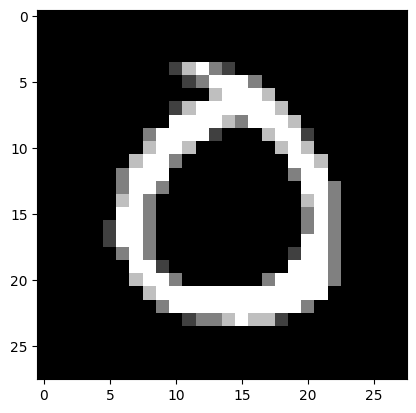

In [37]:
# This function tests the prediction for a specific index in the training dataset using the trained parameters W1, b1, W2, and b2. 
# It prints the prediction, actual label, and displays the corresponding image.

test_prediction(5, W1, b1, W2, b2)

In [51]:
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)


get_accuracy(dev_predictions, Y_test)
data_new = pd.read_csv(r"C:\Users\Martin\Desktop\ComputerScience\Matematica III\TPfinal\datasets\mnist_test.csv")

In [1]:
# We're preprocessing the new dataset in the same way as we did with the training and test datasets
# Followed by normalizing pixel values and reshaping features
# Making sure the preprocessing steps match what we did before

def preprocess_features(data):
    X = data.drop(columns=['label']).values  
    X = X / 255. 
    X = X.reshape(X.shape[0], -1)  
    return X



# Preparing the new dataset features for analysis
X_new = preprocess_features(data_new)


#  Extracts and preprocesses the labels from the dataset
def preprocess_labels(data):
    Y = data['label'].values 
    return Y


# Preprocesses the labels of the new dataset
Y_new = preprocess_labels(data_new)


# Now, using our existing code we run the Data through the Neural Network
# Knowing that we previously have defined functions like forward_prop and get_predictions
_, _, _, A2_new = forward_prop(W1, b1, W2, b2, X_new.T)
predictions_new = get_predictions(A2_new)


# Last Step: Evaluating the Accuracy
# We compare the predictions with the true labels to calculate the accuracy.
accuracy_new = get_accuracy(predictions_new, Y_new)
print("Accuracy on New Dataset:", accuracy_new)

NameError: name 'data_new' is not defined

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageDraw
import numpy as np
import os

# Función para procesar la imagen


# Función para cargar la imagen desde un cuadro de diálogo
def cargar_imagen():
    # Crear una ventana de tkinter oculta
    root = tk.Tk()
    root.withdraw()  # No queremos que aparezca una ventana
    
    # Abrir un cuadro de diálogo para seleccionar una imagen
    ruta_imagen = filedialog.askopenfilename(
        title="Selecciona una imagen",
        filetypes=[("Imágenes PNG", "*.png"), ("Imágenes JPEG", "*.jpg *.jpeg"), ("Todos los archivos", "*.*")]
    )
    
    return ruta_imagen

# Función para procesar la imagen
def procesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = Image.open(ruta_imagen)
    
    # Convertir a escala de grises
    img = img.convert('L')
    
    # Redimensionar a 28x28 píxeles
    img = img.resize((28, 28))
    
    # Convertir la imagen a un array numpy
    img_array = np.array(img)
    
    # Invertir los colores (MNIST tiene fondo negro y trazos blancos)
    img_array = 255 - img_array
    
    # Escalar los valores de los píxeles entre 0 y 1
    img_array = img_array / 255.0
    
    # Aplanar la imagen para que sea un vector de 784 dimensiones (28x28)
    img_array = img_array.flatten()
    
    # Convertir a formato adecuado para el modelo (1 imagen)
    return img_array.reshape(-1, 1)

# Cargar la imagen con un cuadro de diálogo
ruta_imagen = cargar_imagen()

# Si se selecciona una imagen, la procesamos y realizamos la predicción
if ruta_imagen:
    imagen_procesada = procesar_imagen(ruta_imagen)
    
    # Realizar la predicción con el modelo entrenado
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, imagen_procesada)
    
    prediccion = get_predictions(A2)
    
    # Imprimir el resultado de la predicción
    print(f"La predicción para la imagen es: {prediccion[0]}")
else:
    print("No se seleccionó ninguna imagen.")

: 